# TFIDF - N-gram EDA

For this notebook, we will look at TF-IDF to find our optimal number of features when generating our feature files. Instead of using CountVectorizer, we will use the TfidfVectorizor to process our corpus of review bodies.

In our previous notebook, we already determined that a mix of unigram, bigram, and tri-gram gives us the best balance between having meaningful features and features that commonly occur in our reviews. We expect t



# Conclusion

Like BoW, 4000 features for TF-IDF seems to be the most reasonable number of features to use for our training.


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import importlib

%matplotlib inline
sns.set(font_scale=2)

In [2]:
DATA_DIR = "../../dataset/amazon_reviews"

DATA_FILE = f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-2m-preprocessed.csv"

In [3]:
corpus = pd.read_csv(DATA_FILE)
corpus = corpus[["review_body", "star_rating"]].dropna()
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 0 to 1999999
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   review_body  object
 1   star_rating  int64 
dtypes: int64(1), object(1)
memory usage: 45.8+ MB


# Unigram, Bigram, Trigram

We will increase the number of features and compare that to the number of reviews that we would have to remove from our corpus since they don't have any features.

There is a point of diminishing return at around 4000 features number of reviews that we get to keep decreases more slowly as we increase the number of features

In [4]:
missing_features123 = pd.DataFrame()
for max_features in np.arange(1000, 10001, 1000):
    cv = TfidfVectorizer(ngram_range=(1,3), max_features=max_features)
    X = cv.fit_transform(corpus["review_body"])
    missing = len(np.where(~X.toarray().any(axis=1))[0])
    d = {
        "cv": cv,
        "max_features": max_features,
        "samples_with_no_features": missing
    }
    missing_features123 = missing_features123.append(d, ignore_index=True)
    print(f'Number of rows without features using max_features {max_features}: {missing}')

Number of rows without features using max_features 1000: 17970
Number of rows without features using max_features 2000: 11956
Number of rows without features using max_features 3000: 10904
Number of rows without features using max_features 4000: 7898
Number of rows without features using max_features 5000: 7362
Number of rows without features using max_features 6000: 7205
Number of rows without features using max_features 7000: 6565
Number of rows without features using max_features 8000: 5832
Number of rows without features using max_features 9000: 5730
Number of rows without features using max_features 10000: 5635


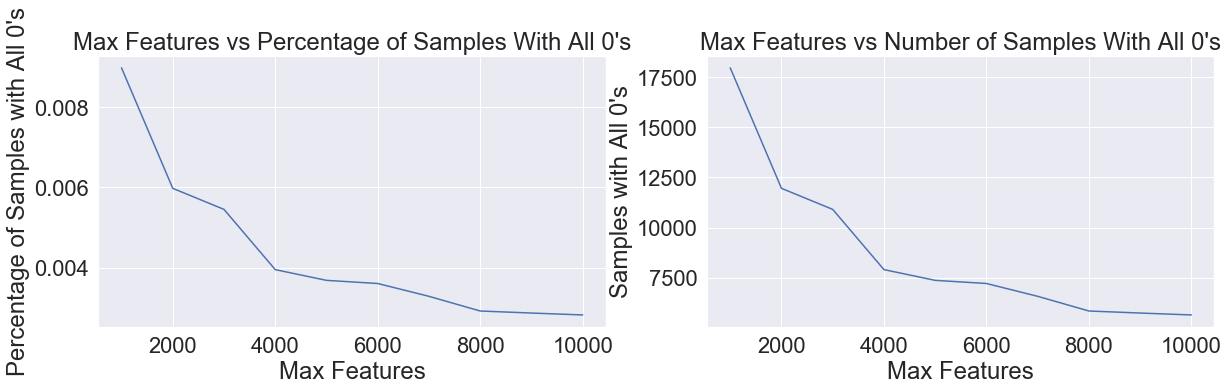

In [5]:
missing_features123["samples_with_no_features_percentage"] = missing_features123["samples_with_no_features"] / len(corpus)

f, a = plt.subplots(1, 2, figsize=(20, 5))
_ = sns.lineplot(data = missing_features123, x = "max_features", y = "samples_with_no_features_percentage", ax=a[0])
_ = a[0].set_title("Max Features vs Percentage of Samples With All 0's")
_ = a[0].set_xlabel("Max Features")
_ = a[0].set_ylabel("Percentage of Samples with All 0's")
_ = sns.lineplot(data = missing_features123, x = "max_features", y = "samples_with_no_features", ax=a[1])
_ = a[1].set_title("Max Features vs Number of Samples With All 0's")
_ = a[1].set_xlabel("Max Features")
_ = a[1].set_ylabel("Samples with All 0's")


# Most popular ngrams

We will look at the most popular TF-IDF ngrams by taking the mean of all columns to come up with a score for each of our ngrams

In [6]:
cv = TfidfVectorizer(ngram_range=(1,3), max_features=3000)
X = cv.fit_transform(corpus["review_body"])
type(X)


scipy.sparse.csr.csr_matrix

In [7]:
ngram_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())

In [8]:
ngram_df.head(2)

,ability,able,able charge,able get,able use,absolutely,absolutely love,abuse,ac,acceptable,...,year ago,year old,yellow,yes,yesterday,yet,youtube,zagg,zero,zune
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here is 50 of the most popular TF-IDF ngrams

In [9]:
ngram_means = ngram_df.mean(axis=0, skipna=True).sort_values(ascending=False)
ngram_means.head(50).index

Index(['not', 'case', 'great', 'phone', 'good', 'love', 'work', 'very',
       'product', 'one', 'fit', 'like', 'would', 'well', 'screen', 'doe',
       'nice', 'will', 'use', 'do', 'ti', 'price', 'get', 'no', 'battery',
       'perfect', 'did', 'look', 'really', 'charge', 'ame', 'quality',
       'iphone', 'doe not', 'easy', 'ti ame', 'cover', 'work great', 'do not',
       'bought', 'charger', 'buy', 'got', 'did not', 'excellent', 'recommend',
       'color', 'little', 'protector', 'item'],
      dtype='object')

# Distribution of unigram, bigram and trigram

* we would like for our features to contain a mix unigram, bi-gram, and tri-gram
* this should be roughly the same as BoW (CountVectorizer)

In [10]:
feature_name = pd.DataFrame(cv.get_feature_names()).rename({0:"feature_name"}, axis=1)
feature_name["wc"] = feature_name.feature_name.apply(lambda x: len(x.split(" ")))
word_count = feature_name.groupby("wc").count().reset_index()
word_count["wc_percentage"] = word_count["feature_name"] / word_count["feature_name"].sum() * 100
word_count

,wc,feature_name,wc_percentage
0,1,1872,62.4
1,2,987,32.9
2,3,141,4.7


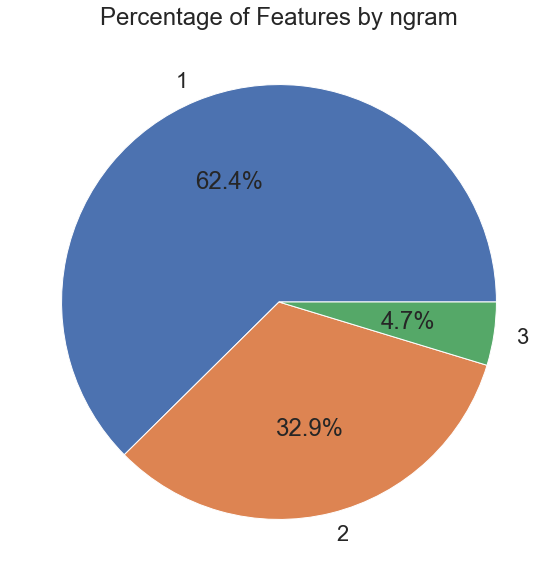

In [11]:
f, a = plt.subplots(1, 1, figsize=(10, 10))
_ = plt.pie(word_count.wc_percentage, labels=word_count.wc, autopct='%1.1f%%')
_ = plt.title("Percentage of Features by ngram")